<a href="https://colab.research.google.com/github/osgeokr/kari-sdm/blob/main/007_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 래스터 정렬
8개 레이어 -> DEM.tif
래스터를 동일한 셀 크기로 리샘플링하고 동일한 좌표계로 재투영해서 정렬
참조 레이어: DEM_scaled

In [2]:
!pip install -q -U rasterio

In [3]:
import pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import os
import numpy as np

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
!wget https://github.com/osgeokr/kari-sdm/raw/main/pitta_nympha_pa_dw.gpkg -O pitta_nympha_pa_dw.gpkg
gdf = gpd.read_file('pitta_nympha_pa_dw.gpkg')
gdf.head(1)

--2024-08-17 11:56:46--  https://github.com/osgeokr/kari-sdm/raw/main/pitta_nympha_pa_dw.gpkg
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/osgeokr/kari-sdm/main/pitta_nympha_pa_dw.gpkg [following]
--2024-08-17 11:56:46--  https://raw.githubusercontent.com/osgeokr/kari-sdm/main/pitta_nympha_pa_dw.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114688 (112K) [application/octet-stream]
Saving to: ‘pitta_nympha_pa_dw.gpkg’

pitta_nympha_pa_dw. 100%[===================>] 112.00K  --.-KB/s    in 0.02s   

2024-08-17 11:56:47 (4.42 MB/s) - ‘pitta_nympha_pa_dw.gpkg’ saved [114688/114688]



,species,status,geometry
0,Pitta nympha,1,POINT (126.69344 33.36925)


In [5]:
# Google Drive를 마운트
drive.mount('/content/drive')

# 경로 설정
folder_path = "/content/drive/My Drive/kari-sdm"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# 좌표에 대한 픽셀 값을 샘플링하여 새 필드 추가
def sample_raster(raster, points_gdf):
    values = []
    for geom in points_gdf.geometry:
        if geom.geom_type == 'Point':
            point = geom
            try:
                for val in raster.sample([(point.x, point.y)]):
                    values.append(val[0])
            except ValueError:
                values.append(None)
        else:
            values.append(None)
    return values

In [7]:
# DEM
img_path = os.path.join(folder_path, "DEM_scaled.tif")
dem = rasterio.open(img_path)
gdf['dem'] = sample_raster(dem, gdf)

# SLP
img_path = os.path.join(folder_path, "SLP_scaled.tif")
slp = rasterio.open(img_path)
gdf['slp'] = sample_raster(slp, gdf)

# ASP
img_path = os.path.join(folder_path, "ASP_scaled.tif")
asp = rasterio.open(img_path)
gdf['asp'] = sample_raster(asp, gdf)

# NDBI
img_path = os.path.join(folder_path, "NDBI_scaled.tif")
ndbi = rasterio.open(img_path)
gdf['ndbi'] = sample_raster(ndbi, gdf)

# NDVI
img_path = os.path.join(folder_path, "NDVI_scaled.tif")
ndvi = rasterio.open(img_path)
gdf['ndvi'] = sample_raster(ndvi, gdf)

# NDWI
img_path = os.path.join(folder_path, "NDWI_scaled.tif")
ndwi = rasterio.open(img_path)
gdf['ndwi'] = sample_raster(ndwi, gdf)

# Canopy Height
img_path = os.path.join(folder_path, "CHT_scaled.tif")
cht = rasterio.open(img_path)
gdf['cht'] = sample_raster(cht, gdf)

# Tree Canopy Cover
img_path = os.path.join(folder_path, "TCC_scaled.tif")
tcc = rasterio.open(img_path)
gdf['tcc'] = sample_raster(tcc, gdf)

# 결과 출력
gdf.head(1)

,species,status,geometry,dem,slp,asp,ndbi,ndvi,ndwi,cht,tcc
0,Pitta nympha,1,POINT (126.69344 33.36925),0.243802,0.125,0.445682,0.290305,0.877249,0.102141,0.617647,0.58046


In [8]:
# NaN 값이 있는 레코드 필터링
nan_gdf = gdf[
    gdf[["dem", "slp", "asp", "ndbi", "ndvi", "ndwi", "cht", "tcc"]].isna().any(axis=1)
]

# NaN 값이 있는 좌표의 개수 출력
nan_count = nan_gdf.shape[0]
print(f"NaN 값이 있는 좌표의 개수: {nan_count}개")

# NaN 값이 있는 좌표를 삭제
gdf_cleaned = gdf.dropna(
    subset=["dem", "slp", "asp", "ndbi", "ndvi", "ndwi", "cht", "tcc"]
)

# NaN이 있는 좌표가 삭제된 결과 출력 (원래 gdf를 gdf_cleaned로 업데이트)
gdf = gdf_cleaned

NaN 값이 있는 좌표의 개수: 1개


In [9]:
# 7:3 비율로 train과 test 데이터셋 나누기
train_gdf, test_gdf = train_test_split(
    gdf, test_size=0.3, random_state=42, stratify=gdf["status"]
)

# 특징 변수와 라벨 준비
X_train = train_gdf[['dem', 'slp', 'asp', 'ndbi', 'ndvi', 'ndwi', 'cht', 'tcc']]
y_train = train_gdf['status']
X_test = test_gdf[['dem', 'slp', 'asp', 'ndbi', 'ndvi', 'ndwi', 'cht', 'tcc']]
y_test = test_gdf['status']

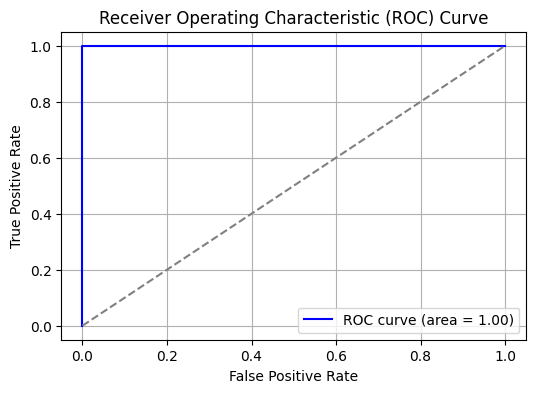

In [10]:
# Logistic Regression 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측 및 ROC 커브 그리기
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [11]:
# SDM 지도 래스터 생성
dem_array = dem.read(1)
slp_array = slp.read(1)
asp_array = asp.read(1)
ndbi_array = ndbi.read(1)
ndvi_array = ndvi.read(1)
ndwi_array = ndwi.read(1)
cht_array = cht.read(1)
tcc_array = tcc.read(1)

In [12]:
# 래스터 배열에서 값이 유효한 위치를 선택하여 모델 예측 수행
valid_mask = (
    ~np.isnan(dem_array)
    & ~np.isnan(slp_array)
    & ~np.isnan(asp_array)
    & ~np.isnan(ndbi_array)
    & ~np.isnan(ndvi_array)
    & ~np.isnan(ndwi_array)
    & ~np.isnan(cht_array)
    & ~np.isnan(tcc_array)
)

In [13]:
X_valid = np.column_stack([dem_array[valid_mask], slp_array[valid_mask], asp_array[valid_mask],
                           ndbi_array[valid_mask], ndvi_array[valid_mask], ndwi_array[valid_mask],
                           cht_array[valid_mask], tcc_array[valid_mask]])

# 모델 예측 수행
y_pred_valid = model.predict_proba(X_valid)[:, 1]

# SDM 예측 결과를 저장할 배열 생성
sdm_map = np.full(dem_array.shape, np.nan)
sdm_map[valid_mask] = y_pred_valid

# GeoTIFF 저장을 위한 메타데이터 설정
transform = dem.transform
meta = dem.meta.copy()
meta.update({
    'dtype': 'float32',
    'count': 1,
    'compress': 'lzw'
})

# GeoTIFF로 저장
output_path = os.path.join(folder_path, "SDM_prediction.tif")
with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(sdm_map, 1)

print(f"SDM prediction map saved to {output_path}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


SDM prediction map saved to /content/drive/My Drive/kari-sdm/SDM_prediction.tif


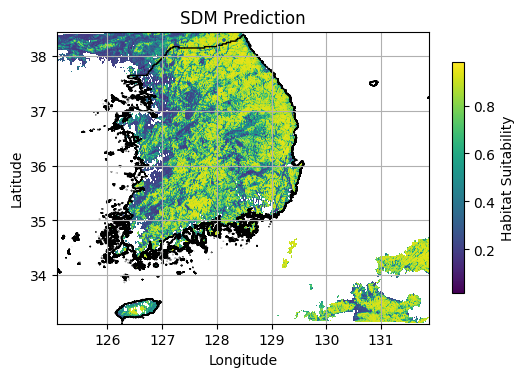

In [14]:
# 경로 설정
folder_path = "/content/drive/My Drive/kari-sdm"
img_path = os.path.join(folder_path, "SDM_prediction.tif")
kr_path = os.path.join(folder_path, "KR.gpkg")

# 대한민국 경계 읽기
kr = gpd.read_file(kr_path)

# 이미지 데이터 읽기
with rasterio.open(img_path) as src:
    img_data = src.read(1)  # 첫 번째 밴드 읽기
    img_extent = src.bounds  # 이미지의 범위 가져오기
    img_transform = src.transform  # 변환 정보 가져오기
    img_meta = src.meta.copy()  # 메타데이터 복사

# 플롯 설정
fig, ax = plt.subplots(figsize=(6, 6))

# 이미지 데이터 플롯 (마스킹 적용)
img_plot = ax.imshow(
    img_data,
    cmap="viridis",
    extent=[img_extent.left, img_extent.right, img_extent.bottom, img_extent.top],
    origin="upper"
)

# 대한민국 경계 플롯
kr.plot(ax=ax, color="none", edgecolor="black")

# 컬러바(범례) 추가
cbar = fig.colorbar(img_plot, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Habitat Suitability')

# 제목, 축 레이블, 그리드 설정
plt.title("SDM Prediction")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# 좌표 비율 유지
ax.set_aspect("equal", "box")

# 플롯 표시
plt.show()